## 이미지 분류기 학습하기

# 1. CIFAR10을 불러오고 정규화하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


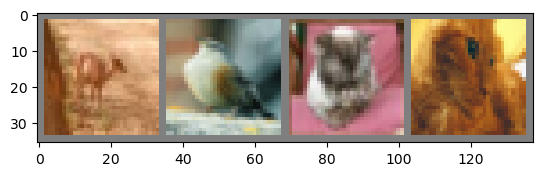

deer  bird  cat   cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
## 2. 합성곱 신경망(Convolution Neural Network) 정의하기

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
## 3. 손실 함수와 Optimizer 정의하기

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
## 4. 신경망 학습하기

for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.192
[1,  4000] loss: 1.834
[1,  6000] loss: 1.669
[1,  8000] loss: 1.575
[1, 10000] loss: 1.528
[1, 12000] loss: 1.458
[2,  2000] loss: 1.389
[2,  4000] loss: 1.357
[2,  6000] loss: 1.353
[2,  8000] loss: 1.333
[2, 10000] loss: 1.328
[2, 12000] loss: 1.290
Finished Training


In [7]:
# 학습된 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

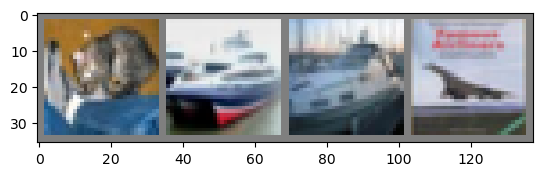

GroundTruth:  cat   ship  ship  plane


In [8]:
## 5. 시험용 데이터로 신경망 검사하기

# 지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다. 신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.
# 신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다. 만약 예측이 맞다면 샘플을 〈맞은 예측값(correct predictions)〉 목록에 넣겠습니다.
# 첫번째로 시험용 데이터를 좀 보겠습니다.

dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
# 이제, 저장했던 모델을 불러오도록 하겠습니다

net = Net()
net.load_state_dict(torch.load(PATH))

C:\Users\fcsol\AppData\Local\Temp\ipykernel_21068\2813319615.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [12]:
# 예제들을 신경망이 어떻게 예측했는지 보기

outputs = net(images)

# 출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이 나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
# 따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  ship 


In [13]:
# 그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [14]:
#어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보기

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 47.8 %
Accuracy for class: car   is 68.2 %
Accuracy for class: bird  is 31.9 %
Accuracy for class: cat   is 56.6 %
Accuracy for class: deer  is 50.1 %
Accuracy for class: dog   is 27.1 %
Accuracy for class: frog  is 68.4 %
Accuracy for class: horse is 68.0 %
Accuracy for class: ship  is 59.2 %
Accuracy for class: truck is 62.6 %


In [17]:
## GPU에서 학습하기

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다: 단, 이 기기는 노트북이라서 없습니다.
print(device)

cpu


In [ ]:
# 이 메소드(Method)들은 재귀적으로 모든 모듈의 매개변수와 버퍼를 CUDA tensor로 변경합니다.
net.to(device)

# 또한, 각 단계에서 입력(input)과 정답(target)도 GPU로 보내야 한다는 것도 기억해야 합니다
inputs, labels = data[0].to(device), data[1].to(device)

## CPU와 비교했을 때 어마어마한 속도 차이가 나지 않는 것은 왜 그럴까요? 그 이유는 바로 신경망이 너무 작기 때문입니다.